In [1]:
from typing import Optional

import matplotlib.pyplot as plt
import pandas as pd

In [6]:
def panelview(
    data: pd.DataFrame,
    unit: str,
    time: str,
    treat: str,
    outcome: Optional[str] = None,
    collapse_to_cohort: Optional[bool] = False,
    subsamp: Optional[int] = None,
    units_to_plot: Optional[list] = None,
    sort_by_timing: Optional[bool] = False,
    xlab: Optional[str] = None,
    ylab: Optional[str] = None,
    figsize: Optional[tuple] = (11, 3),  # Default plot size
    noticks: Optional[bool] = False,
    title: Optional[str] = None,
    legend: Optional[bool] = False,
    ax: Optional[plt.Axes] = None,
    xlim: Optional[tuple] = None,
    ylim: Optional[tuple] = None,
) -> None:
    """
    Generate a panel view of the treatment variable over time for each unit.

    Parameters
    ----------
    data : pandas.DataFrame
        The input dataframe containing the data.
    unit : str
        The column name representing the unit identifier.
    time : str
        The column name representing the time identifier.
    treat : str
        The column name representing the treatment variable.
    outcome : str, optional
        The column name representing the outcome variable. If not None, an outcome plot is generated.
    collapse_to_cohort : bool, optional
        Whether to collapse units into treatment cohorts.
    subsamp : int, optional
        The number of samples to draw from data set for display (default is None).
    sort_by_timing : bool, optional
        Whether to sort the treatment cohorts by the number of treated periods.
    xlab : str, optional
        The label for the x-axis. Default is None, in which case default labels are used.
    ylab : str, optional
        The label for the y-axis. Default is None, in which case default labels are used.
    figsize : tuple, optional
        The figure size for the outcome plot. Default is (11, 3).
    noticks : bool, optional
        Whether to display ticks on the plot. Default is False.
    title : str, optional
        The title for the plot. Default is None, in which case no title is displayed.
    legend : bool, optional
        Whether to display a legend. Default is False (since binary treatments are
        self-explanatory).
    ax : matplotlib.pyplot.Axes, optional
        The axes on which to draw the plot. Default is None, in which case a new figure
        is created.
    xlim : tuple, optional
        The limits for the x-axis of the plot. Default is None.
    ylim : tuple, optional
        The limits for the y-axis of the plot. Default is None.
    units_to_plot : list, optional
        A list of unit to include in the plot. If None, all units in the dataset are plotted.

    Returns
    -------
    ax : matplotlib.pyplot.Axes

    Examples
    --------
    ```python
    import pandas as pd
    import numpy as np
    import pyfixest as pf

    df_het = pd.read_csv("pd.read_csv("pyfixest/did/data/df_het.csv")

    # Inspect treatment assignment
    pf.panelview(
        data = df_het,
        unit = "unit",
        time = "year",
        treat = "treat",
        subsamp = 50,
        title = "Treatment Assignment"
    )

    # Outcome plot
    pf.panelview(
        data = df_het,
        unit = "unit",
        time = "year",
        outcome = "dep_var",
        treat = "treat",
        subsamp = 50,
        title = "Outcome Plot"
    )
    ```
    """
    # check if unit, time, treat and outcome are in the data
    for col in [unit, time, treat]:
        if col not in data.columns:
            raise ValueError(f"Column '{col}' not found in data.")
    if outcome and outcome not in data.columns:
        raise ValueError(f"Outcome column '{outcome}' not found in data.")

    if collapse_to_cohort and (subsamp or units_to_plot):
        raise ValueError(
            "Cannot use 'collapse_to_cohort' together with 'subsamp' or 'units_to_plot'."
        )

    if outcome:
        data_pivot = _prepare_panelview_df_for_outcome_plot(
            data=data,
            unit=unit,
            time=time,
            treat=treat,
            outcome=outcome,
            subsamp=subsamp,
            collapse_to_cohort=collapse_to_cohort,
            units_to_plot=units_to_plot,
        )

        return _plot_panelview_output_plot(
            data_pivot=data_pivot,
            data=data,
            unit=unit,
            time=time,
            treat=treat,
            outcome=outcome,
            ax=ax,
            xlab=xlab,
            ylab=ylab,
            title=title,
            legend=legend,
            xlim=xlim,
            ylim=ylim,
            figsize=figsize,
        )

    else:
        treatment_quilt = _prepare_df_for_panelview(
            data=data,
            unit=unit,
            time=time,
            treat=treat,
            subsamp=subsamp,
            collapse_to_cohort=collapse_to_cohort,
            sort_by_timing=sort_by_timing,
        )

        return _plot_panelview(
            treatment_quilt=treatment_quilt,
            ax=ax,
            xlab=xlab,
            ylab=ylab,
            legend=legend,
            noticks=noticks,
            title=title,
        )


def _prepare_panelview_df_for_outcome_plot(
    data: pd.DataFrame,
    unit: str,
    time: str,
    treat: str,
    outcome: str,
    subsamp: Optional[int] = None,
    collapse_to_cohort: Optional[bool] = None,
    units_to_plot: Optional[list[str]] = None,
) -> pd.DataFrame:
    if units_to_plot:
        data = data[data[unit].isin(units_to_plot)]

    data_pivot = data.pivot(index=unit, columns=time, values=outcome)

    if subsamp:
        data_pivot = data_pivot.sample(subsamp)

    if collapse_to_cohort:

        def get_treatment_start(x: pd.DataFrame) -> pd.Timestamp:
            return x[x[treat]][time].min()

        treatment_starts = (
            data.groupby(unit)
            .apply(get_treatment_start)
            .reset_index(name="treatment_start")
        )

        data = data.merge(treatment_starts, on=unit, how="left")
        data_agg = (
            data.groupby(["treatment_start", time], dropna=False)[outcome]
            .mean()
            .reset_index()
        )

        data_agg[treat] = data_agg.apply(
            lambda row: row[time] >= row["treatment_start"]
            if pd.notna(row["treatment_start"])
            else False,
            axis=1,
        )

        data_agg = data_agg.rename(columns={"treatment_start": unit})
        data = data_agg.copy()
        data_pivot = data_agg.pivot(index=unit, columns=time, values=outcome)

    return data_pivot


def _plot_panelview_output_plot(
    data: pd.DataFrame,
    data_pivot: pd.DataFrame,
    unit: str,
    time: str,
    treat: str,
    outcome: str,
    ax: Optional[plt.Axes] = None,
    xlab: Optional[str] = None,
    ylab: Optional[str] = None,
    title: Optional[str] = None,
    legend: Optional[bool] = None,
    xlim: Optional[tuple[float, float]] = None,
    ylim: Optional[tuple[float, float]] = None,
    figsize: Optional[tuple] = (11, 3),
) -> plt.Axes:
    if not ax:
        f, ax = plt.subplots(figsize=figsize, dpi=300)
    for unit_id in data_pivot.index:
        unit_data = data_pivot.loc[unit_id]
        treatment_times = data[(data[unit] == unit_id) & (data[treat])][time]

        # If the unit never receives treatment, plot the line in grey
        if treatment_times.empty:
            ax.plot(
                unit_data.index,
                unit_data.values,
                color="#999999",
                linewidth=0.5,
                alpha=0.5,
            )
        else:
            treatment_start = treatment_times.min()

            # Plot the entire line with the initial color (orange), then change to red after treatment
            ax.plot(
                unit_data.index,
                unit_data.values,
                color="#FF8343",
                linewidth=0.5,
                label=f"Unit {unit_id}" if legend else None,
                alpha=0.5,
            )
            ax.plot(
                unit_data.index[unit_data.index >= treatment_start],
                unit_data.values[unit_data.index >= treatment_start],
                color="#ff0000",
                linewidth=0.9,
                alpha=0.5,
            )

    ax.set_xlabel(xlab if xlab else time)
    ax.set_ylabel(ylab if ylab else outcome)
    ax.set_title(
        title if title else "Outcome over Time with Treatment Effect",
        fontweight="bold",
    )
    ax.grid(True, color="#e0e0e0", linewidth=0.3, linestyle="-")
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    if legend:
        custom_lines = [
            plt.Line2D([0], [0], color="#999999", lw=1.5),
            plt.Line2D([0], [0], color="#FF8343", lw=1.5),
            plt.Line2D([0], [0], color="#ff0000", lw=1.5),
        ]
        ax.legend(
            custom_lines,
            ["Control", "Treatment (Pre)", "Treatment (Post)"],
            loc="upper center",
            bbox_to_anchor=(0.5, -0.15),
            ncol=3,
            frameon=False,
        )

    return ax


def _prepare_df_for_panelview(
    data: pd.DataFrame,
    unit: str,
    time: str,
    treat: str,
    subsamp: Optional[int] = None,
    collapse_to_cohort: Optional[bool] = None,
    sort_by_timing: Optional[bool] = None,
) -> pd.DataFrame:
    treatment_quilt = data.pivot(index=unit, columns=time, values=treat)
    treatment_quilt = treatment_quilt.sample(subsamp) if subsamp else treatment_quilt
    if collapse_to_cohort:
        treatment_quilt = treatment_quilt.drop_duplicates()
    if sort_by_timing:
        treatment_quilt = treatment_quilt.loc[
            treatment_quilt.sum(axis=1).sort_values().index
        ]

    return treatment_quilt


def _plot_panelview(
    treatment_quilt: pd.DataFrame,
    ax: Optional[plt.Axes] = None,
    xlab: Optional[str] = None,
    ylab: Optional[str] = None,
    legend: Optional[bool] = False,
    noticks: Optional[bool] = False,
    title: Optional[str] = None,
) -> plt.Axes:
    if not ax:
        f, ax = plt.subplots()
    cax = ax.matshow(treatment_quilt, cmap="viridis", aspect="auto")
    f.colorbar(cax) if legend else None
    ax.set_xlabel(xlab) if xlab else None
    ax.set_ylabel(ylab) if ylab else None

    if noticks:
        ax.set_xticks([])
        ax.set_yticks([])
    if title:
        ax.set_title(title)

    return ax

In [7]:
df_het = pd.read_csv("data/df_het.csv")

In [8]:
import pyfixest as pf

<Axes: title={'center': 'Outcome over Time with Treatment Effect'}, xlabel='year', ylabel='dep_var'>

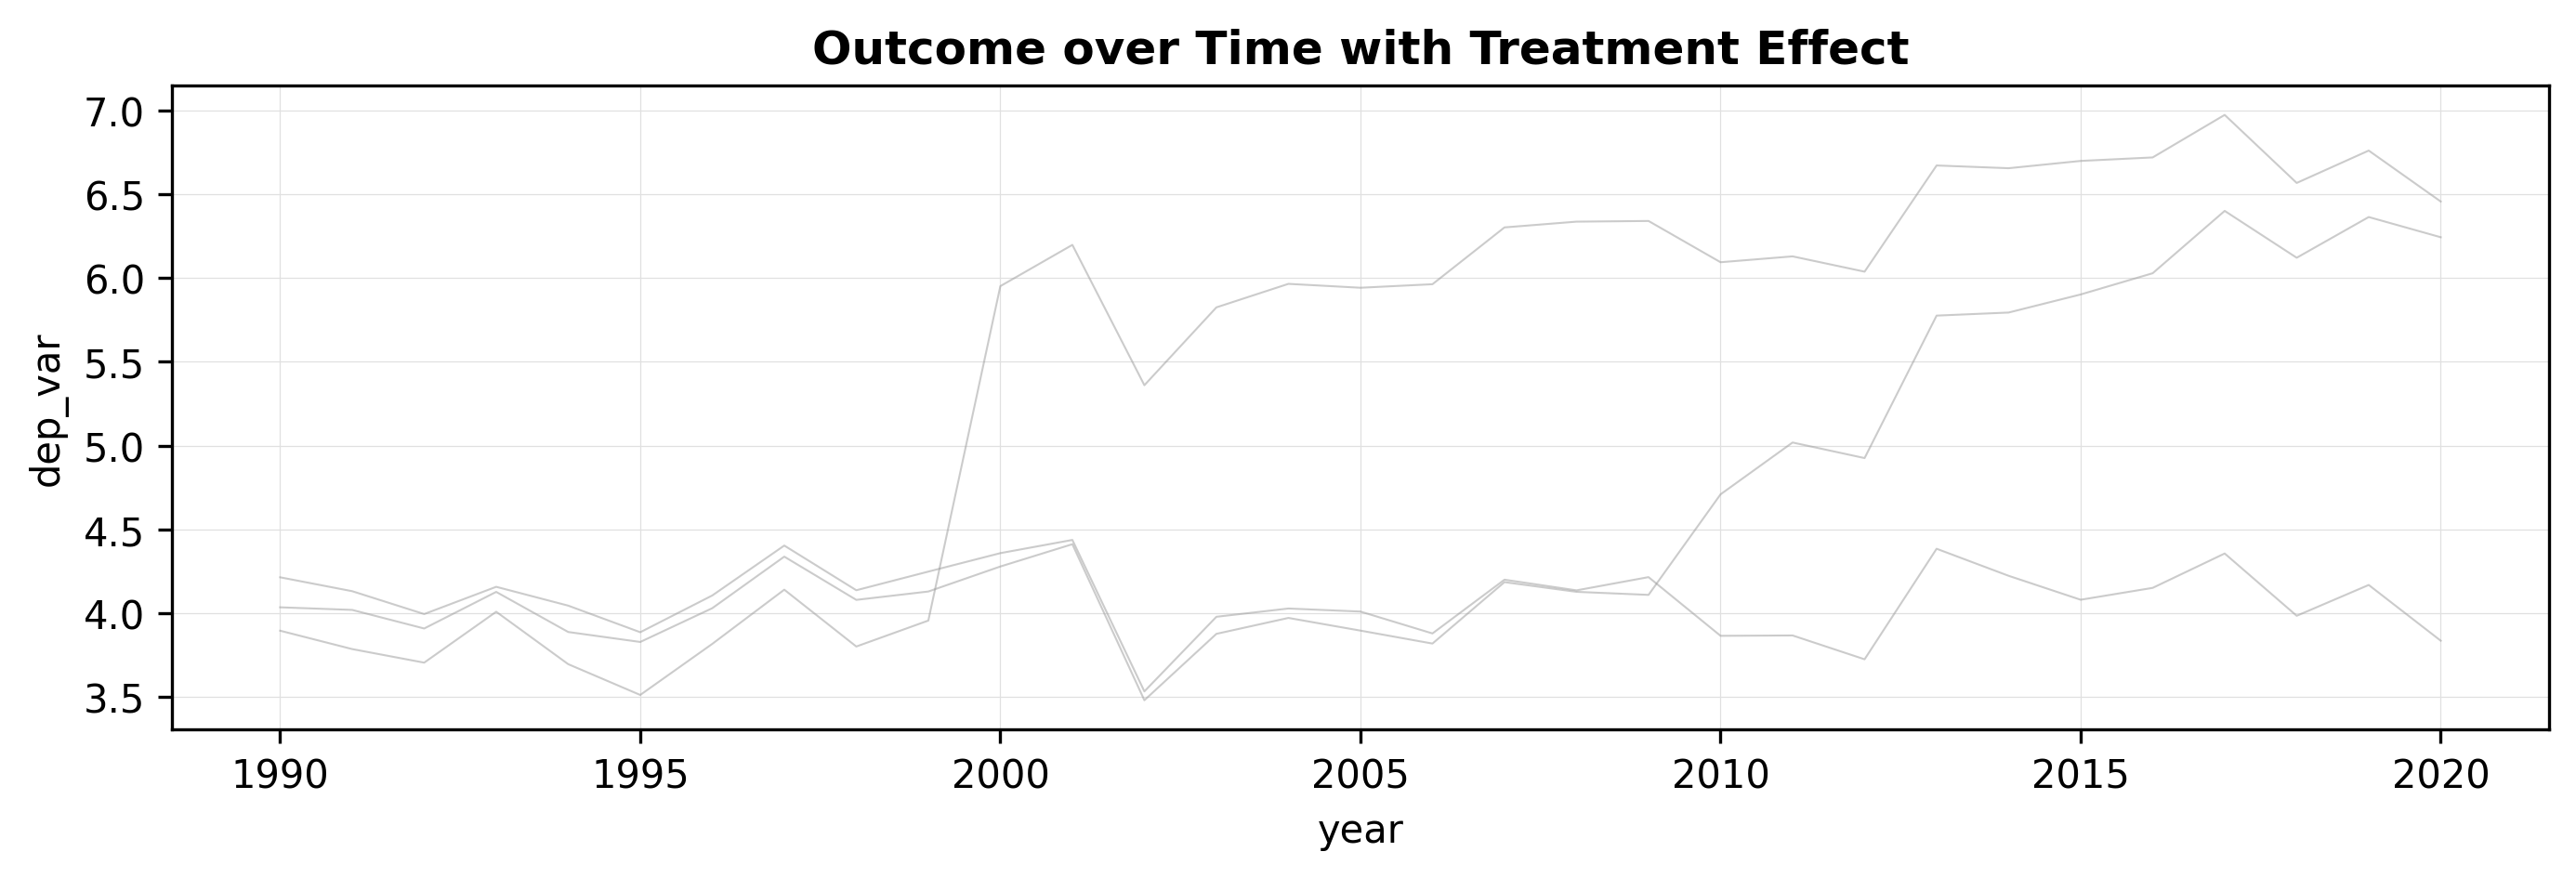

In [9]:
panelview(
        data=df_het,
        outcome="dep_var",
        unit="unit",
        time="year",
        treat="treat",
        collapse_to_cohort=True,
    )